# STITCHES Quickstarter

The purpose of this tutorial is to demonstrate how `stitches` can be used as an emulator. While `stitches` can
 emulate a number of CMIP6 models this example will focus on emulating CanESM5 SSP245 results.

To use `stitches`, there are a number of decisions users have to make,
perhaps the most important being:

* Which ESM will `stitches` emulate?
* What archive data will be used? These are values that the target data will be matched to. It should only
contain data for the specific ESM that is being emulated. Users may limit the number of experiments or
ensemble realizations within the archive in order to achieve their specific experimental setup.
* What target data will be used? This data frame represents the temperature pathway the stitched product
will follow. The contents of this data frame may come from CMIP6 ESM results for an SSP or it may follow
some arbitrary pathway.

A diagram illustrating the `stitches` process is included for reference:

![stitches workflow](figs/stitches_diagram.jpg)

- `stitches` defaults to $X=9$ year windows.


## Getting Started

Start by loading the stitches package (see [installation instructions](https://github.com/jgcri/stitches)
if `stitches` is not yet installed).

In [1]:
import stitches


Load the additional python libraries that will be used in this example.  These packages are installed as `stitches` dependencies.

In [2]:
import pkg_resources

import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt


# For help with plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6


## Install the package data from Zenodo

The package data is all data that has been processed from raw Pangeo data
 and is generated with package functions. For convenience and rapid cloning
 of the github repository, the package data is also minted on Zenodo and
 can be quickly downloaded for using the package.
 

In [4]:
stitches.install_package_data()


Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/matching_archive.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/pangeo_comparison_table.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/pangeo_table.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/matching_archive_staggered.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/NorESM2-LM_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/NorESM2-MM_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/BCC-ESM1_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/CESM2-FV2_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/CAS-ESM2-0_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/CMCC-CM2-SR5_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/MIROC6_tas.c

## Example 1: Emulate global mean air temperature

We will begin with an example focused on emulating global mean air
temperature before moving on to an example producing gridded data for
multiple variables.

The global mean air temperature (GSAT) is the key variable upon which
`stitches` operates to construct new realizations, with the added benefit that it is easy to visualize.

### Example Set Up

In this example, we will use `stitches` to emulate CanESM5 SSP245 results. Then we will compare the
`stitches` results with actual CMIP6 CanESM5 SSP245 output data.

#### Decide on the archive data

- Limit the archive matching data to the model we are trying to emulate, CanESM5 in this case.
- In this example, we treat SSP245 as a novel scenario rather than one
run by the ESM and available, so we exclude it from the archive data.
- The internal package data called `matching_archive` contains the temperature results for all the ESMs-Scenarios-ensemble
members that are available for `stitches` to use in its matching process. In this file monthly, tas output
has been processed to mean temperature anomaly and the temperature change over a window of time. By default
`stitches` uses a 9-year window.

In [5]:
# read in the package data of all ESMs-Scenarios-ensemble members avail.
path = pkg_resources.resource_filename('stitches', 'data/matching_archive.csv')
data = pd.read_csv(path)

archive_data = data.loc[(data["experiment"].isin(['ssp126',  'ssp370', 'ssp585'])) 
                       & (data["model"] == "CanESM5")].copy()


#### Modify Inputs - Decide on the target data

- The primary input to `stitches` functions that most users will adjust is the target data.

- The target data is the temperature pathway the stitched (emulated) product will follow. This data can come from an ESM or
another class of climate models, for a specific SSP scenario or an arbitrarily defined scenario. Similarly to the archive
data, the target data should contain the mean temperature anomaly and rate of temperature change over a window of time.
The target data window and the archive window must be the same length, `stitches` uses a 9-year window by default.
- In this example because we are demonstrating `stitches` ability to emulate CanESM5 SSP245, we will use CanESM5 SSP245
results for a single ensemble member to use as our target data.


In [3]:
# Load time series and subset to target time series if needed:
targ = pd.read_csv(pkg_resources.resource_filename('stitches',
                                                   'data/tas-data/CanESM5_tas.csv'))
target_data = targ.loc[(targ["model"] == "CanESM5")
                       & (targ["experiment"] == 'ssp245')].copy()
target_data  = target_data[target_data["ensemble"].isin(['r1i1p1f1'])].copy()

target_data = target_data.drop(columns='zstore').reset_index(drop=True)

Take a look at the structure and a plot of the time series we will be targeting:

  variable experiment  ensemble    model  year     value
0      tas     ssp245  r1i1p1f1  CanESM5  1850 -1.133884
1      tas     ssp245  r1i1p1f1  CanESM5  1851 -1.389375
2      tas     ssp245  r1i1p1f1  CanESM5  1852 -1.318175
3      tas     ssp245  r1i1p1f1  CanESM5  1853 -1.163771
4      tas     ssp245  r1i1p1f1  CanESM5  1854 -1.302066


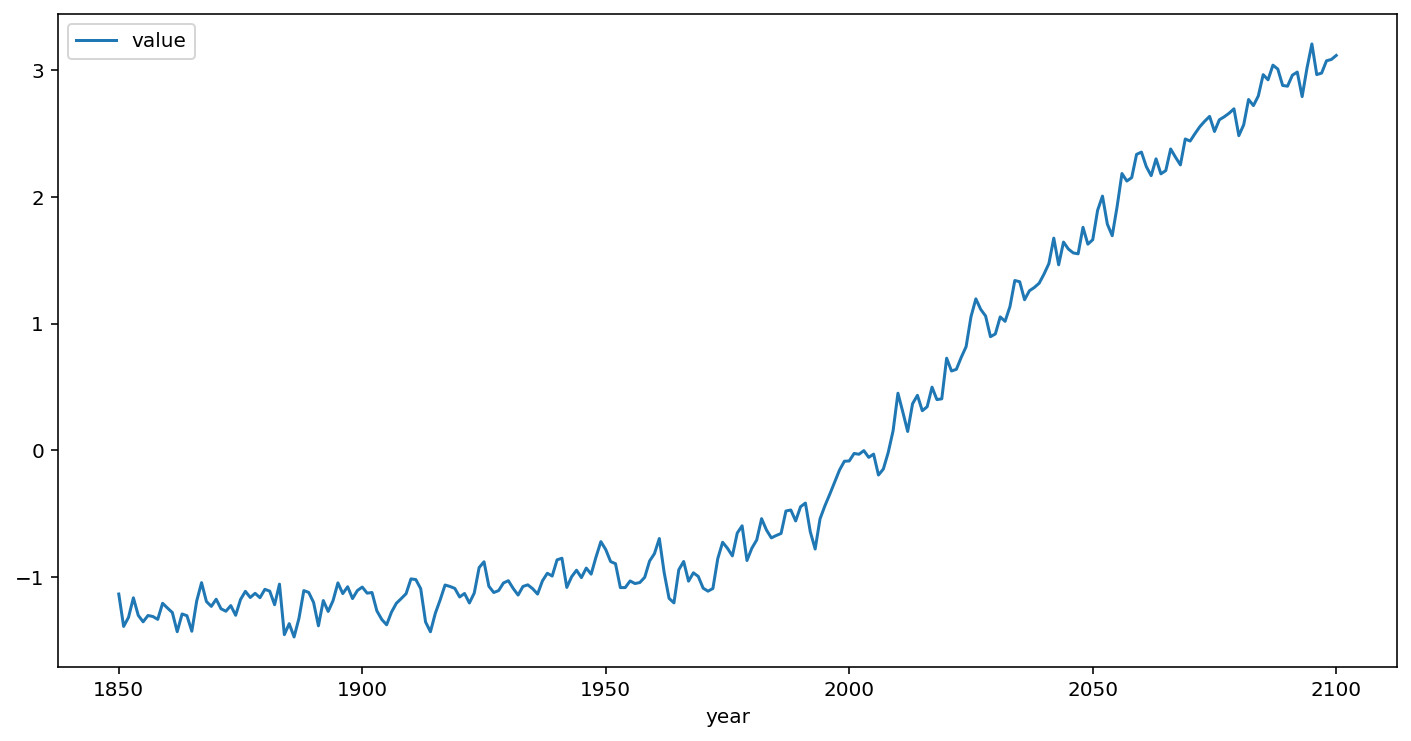

In [4]:
print(target_data.head())
target_data.plot(x='year', y='value')
plt.show()

- Any time series of global average temperature anomalies can be used as a
target. However, the data frame containing this time series must be structured as
above: a `variable` column containing entries of 'tas',  `year` and `value`
columns containing the data, and `experiment`, `ensemble`, `model` columns
with identifying information of the source of this target data.
- The actual entries in the `experiment`, `ensemble`, `model` columns are only
used for generating identifying strings for generated ensemble members.


- In this demonstration, we will specifically be targeting ensemble member 1
of the CanESM5 SSP245 simulations. The entire SSP245 ensemble may be
jointly targeted by omitting the line
`target_data  = target_data[target_data["ensemble"].isin(['r1i1p1f1'])].copy()`

#### Modify Inputs - Prepare target data for matching

`stitches` includes functions that convert the above data frame of raw target
data into correctly structured target data for matching.

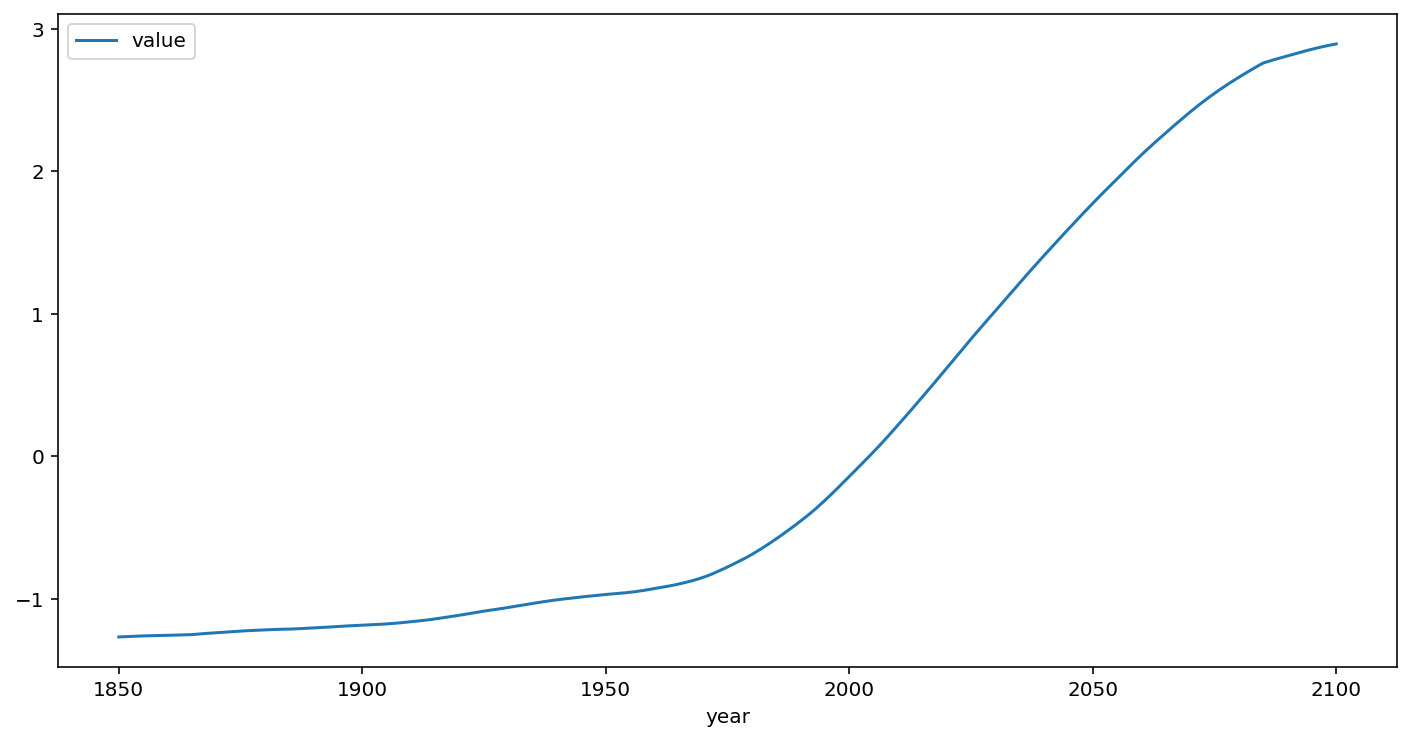

/Users/snyd535/Documents/GitHub/stitches/stitches/fx_processing.py:116: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  extra_info = df[extra_columns].drop_duplicates()
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_processing.py:155: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fx_dx_info = fx_dx_info.append(row)
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_processing.py:155: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fx_dx_info = fx_dx_info.append(row)
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_processing.py:155: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fx_dx_info = fx_dx_info.append(row)
/Users/snyd535/Documents/GitHub/sti

     model variable experiment  ensemble  start_yr  end_yr  year        fx  \
0  CanESM5      tas     ssp245  r1i1p1f1      1850    1858  1854 -1.260607   
1  CanESM5      tas     ssp245  r1i1p1f1      1859    1867  1863 -1.252674   
2  CanESM5      tas     ssp245  r1i1p1f1      1868    1876  1872 -1.232601   
3  CanESM5      tas     ssp245  r1i1p1f1      1877    1885  1881 -1.215855   
4  CanESM5      tas     ssp245  r1i1p1f1      1886    1894  1890 -1.203397   

         dx  
0  0.001201  
1  0.001335  
2  0.002327  
3  0.001281  
4  0.001846  


/Users/snyd535/Documents/GitHub/stitches/stitches/fx_processing.py:155: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fx_dx_info = fx_dx_info.append(row)
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_processing.py:155: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fx_dx_info = fx_dx_info.append(row)
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_processing.py:155: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fx_dx_info = fx_dx_info.append(row)
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_processing.py:155: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fx_dx_info = fx_dx_info.append(row)
/Users/snyd535/Documents/Git

In [6]:
# First, smooth the target data
target_data = stitches.fx_processing.calculate_rolling_mean(target_data,
                                                            size =31).copy()
target_data.plot(x='year', y='value')
plt.show()

# then process so it can be matched on:
target_data = stitches.fx_processing.get_chunk_info(
    stitches.fx_processing.chunk_ts(df = target_data,  n=9)).copy()


#### Use the target_data and archive_data to make the recipes using the function `make_recipe()`

- We ask for 4 new realizations to be constructed, and we specify that
the matching be limited to a `tol`  ($Z$ in the diagram) value of 0.06degC.
- `tol` is the parameter that effectively controls both the maximum number
of generated time series that may be constructed and the quality of matches.
- For large values of `tol`, the matches constructed may be no good.
Currently, the cutoff values of `tol` for each ESM are determined by post-hoc
calculation, as described in the ESD paper.

In [5]:
my_recipes = stitches.make_recipe(target_data, 
                                  archive_data,
                                  tol=0.06, 
                                  N_matches=4)


You have requested more recipes than possible for at least one target trajectories, returning what can


**NOTE** the message that the requested number of matches (4)  is more than
this archive + `tol` combination can support. Results for as many realizations
as possible are returned.


Now use the recipe to get the global mean air temperature using `gmat_stitching`.
The data frame returned by `gmat_stitching` will contain the final stitched product.


In [6]:
stitched_global_temp = stitches.gmat_stitching(my_recipes)


/Users/d3y010/repos/github/stitches/stitches/fx_stitch.py:338: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, match in rp.groupby(['stitching_id']):


#### Visualize Results


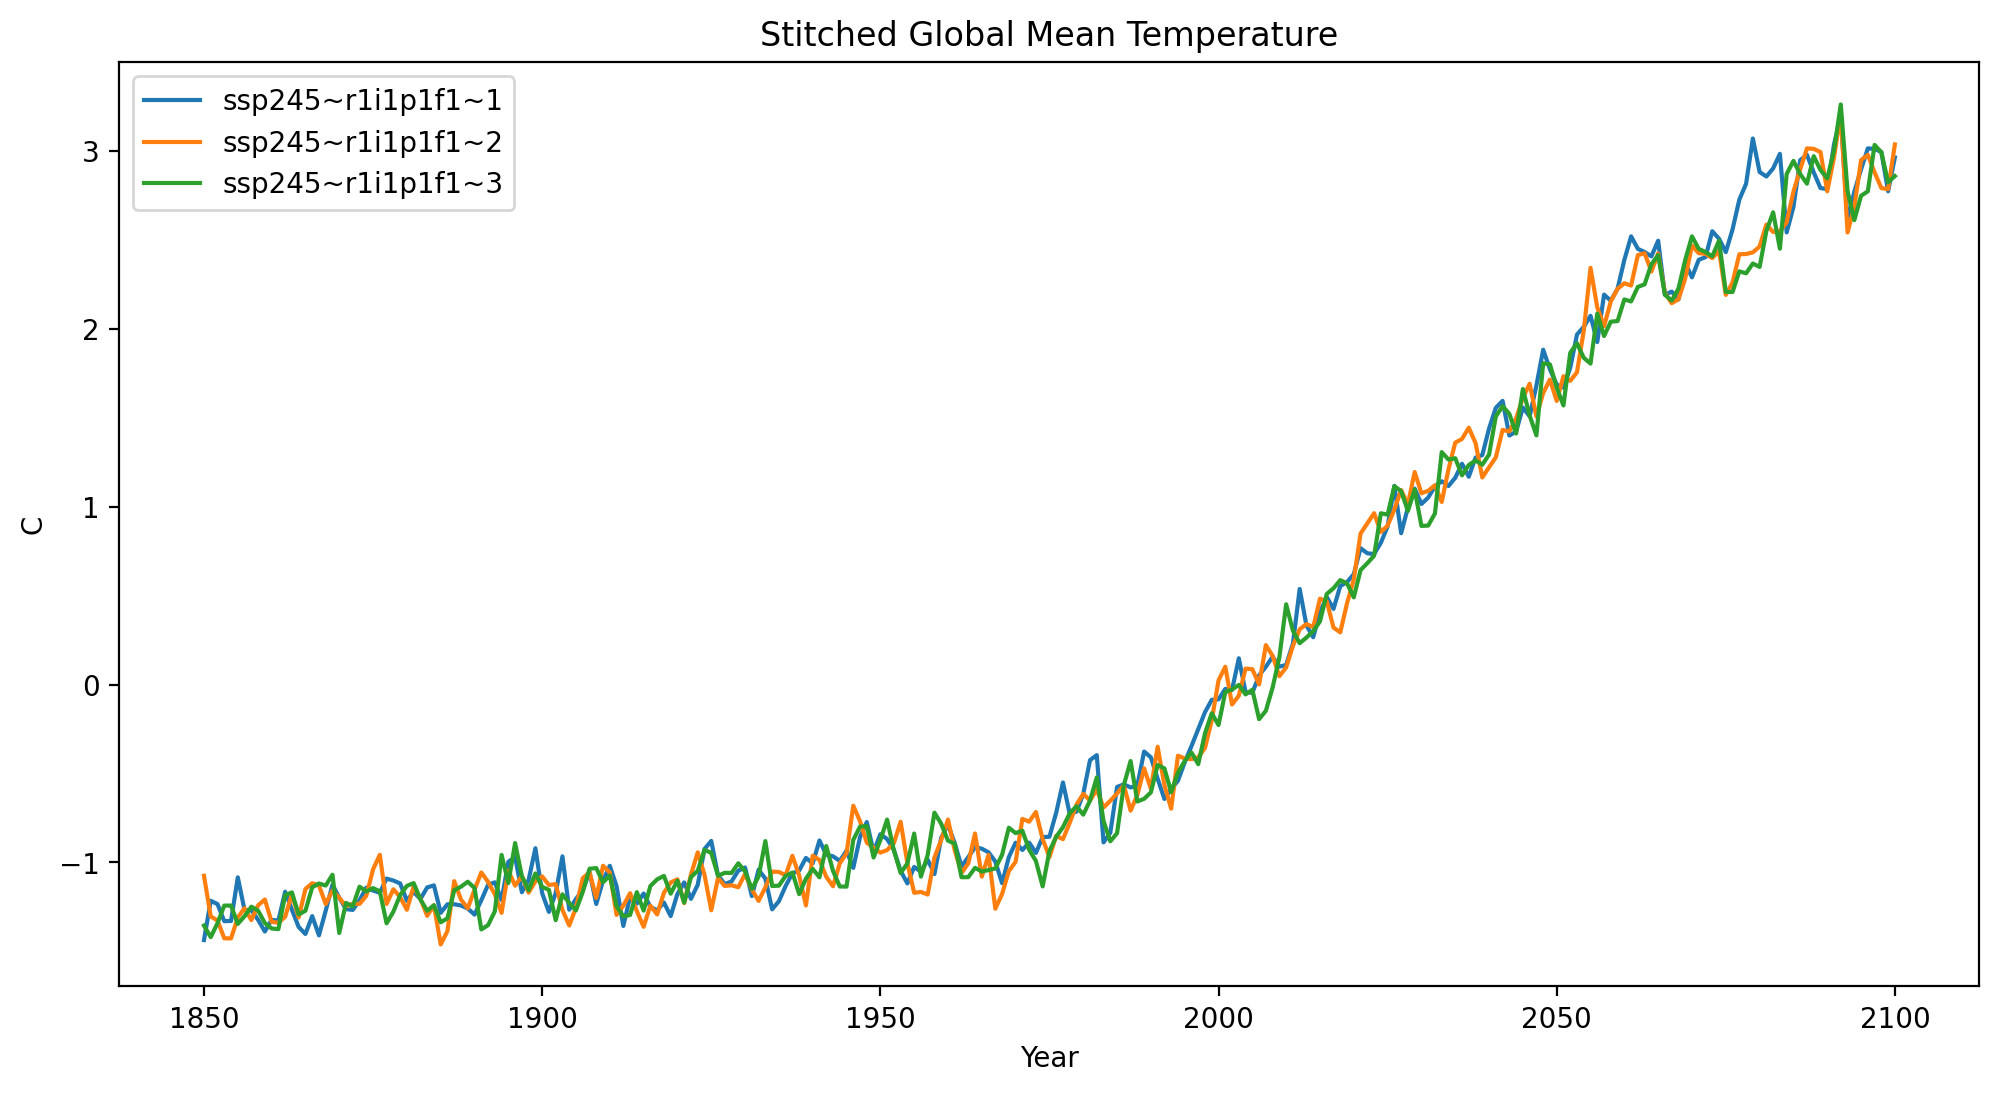

In [7]:
groups = stitched_global_temp.groupby('stitching_id')

for name, group in groups:
    plt.plot(group.year, group.value, label = name)
    
plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature")
plt.legend()
plt.show()
plt.close()


#### Now let's compare the stitched products with the actual CanESM5 SSP245 data
- The black curve is realization 1 - the ESM data that this notebook actually targeted.
- The gray curves are the other archived realizations of SSP245 for CanESM5
to illustrate that the generated ensemble members do not systematically
depart from the actual ensemble behavior.
- GSAT data is included as package data in `stitches` for convenience.


In [8]:
# Load the comparison GSAT data
data_path = pkg_resources.resource_filename('stitches', 'data/tas-data/CanESM5_tas.csv')

comp_data = pd.read_csv(data_path)
comp_data = comp_data.loc[comp_data["experiment"] == "ssp245"]


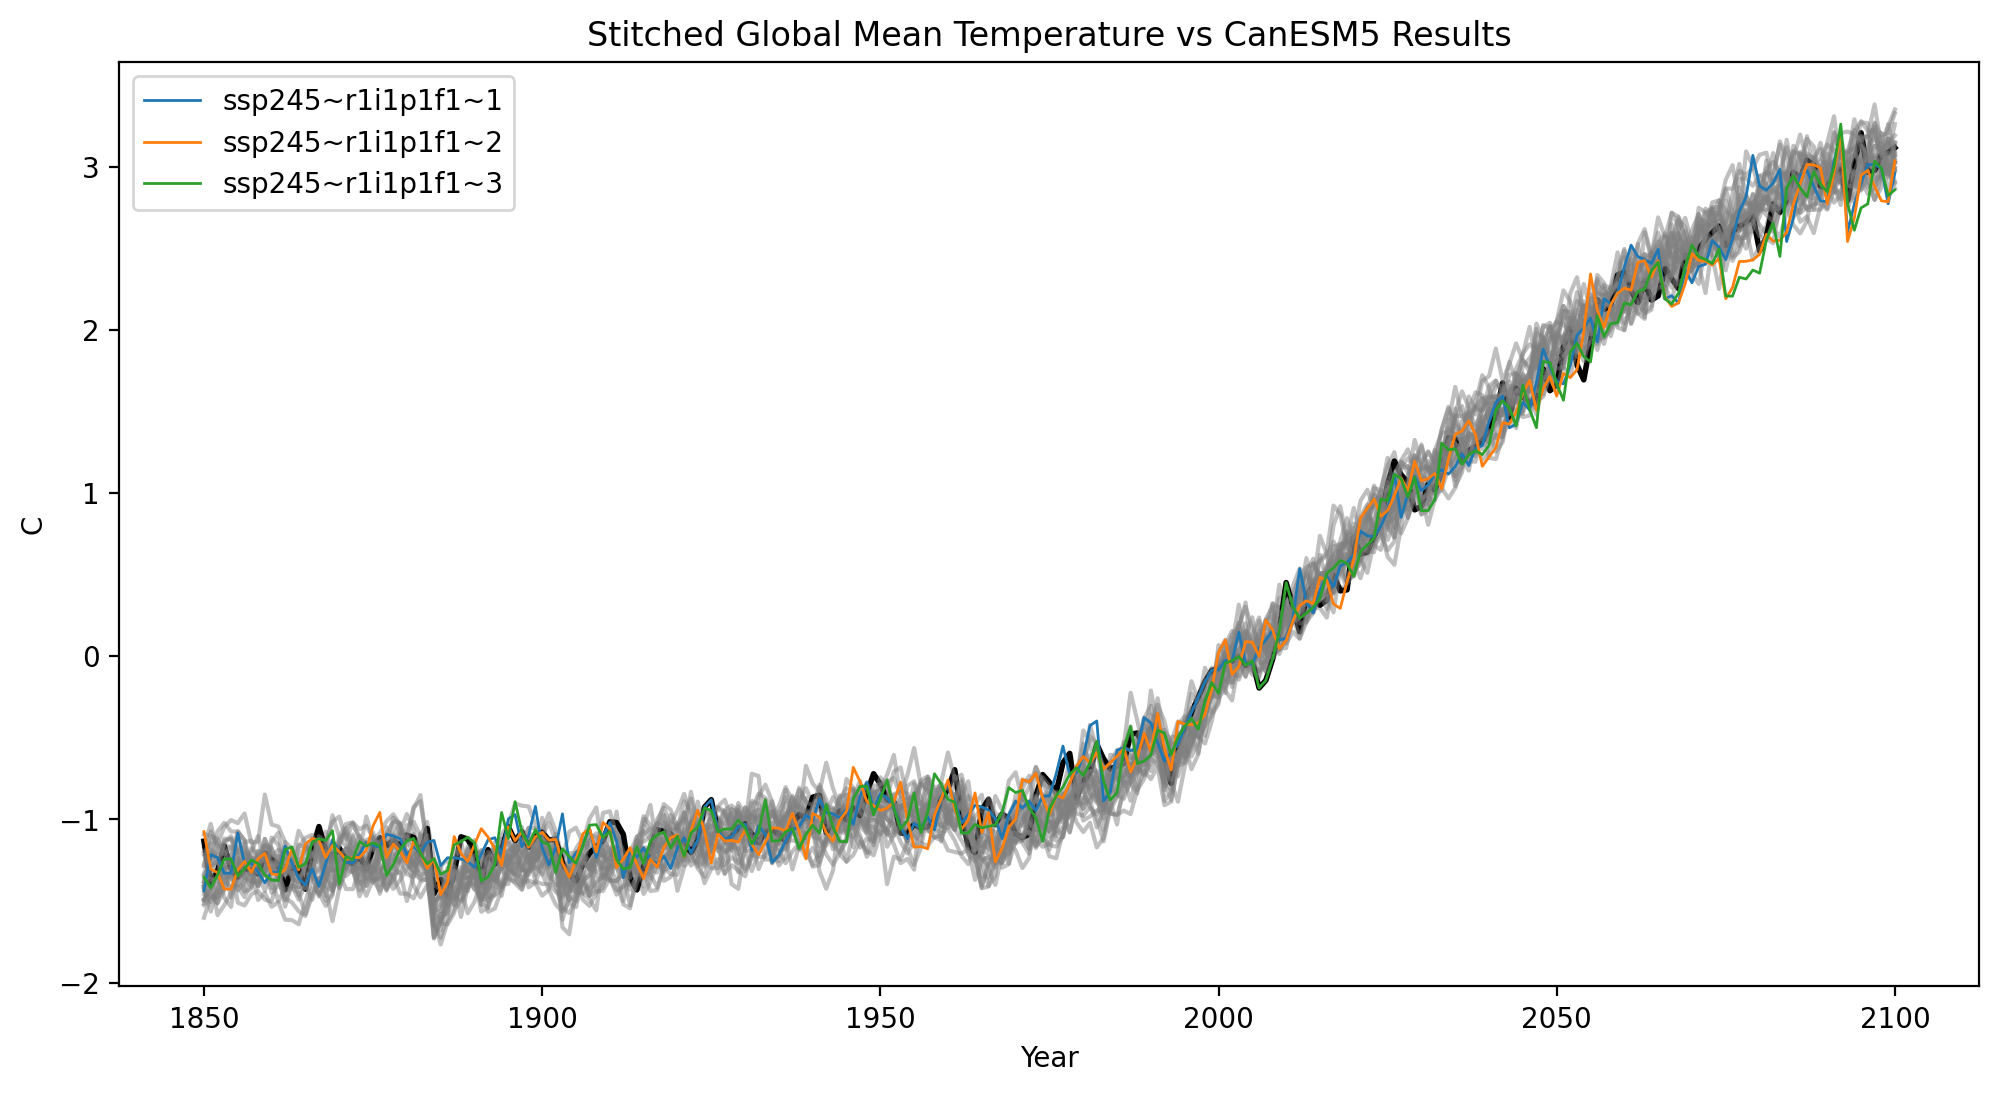

In [9]:
# full ensemble of actual ESM runs:
groups = comp_data.groupby('ensemble')
for name, group in groups:
    if(group.ensemble.unique() == 'r1i1p1f1'):
        plt.plot(group.year, group.value, color = "black", linewidth = 2.0)
    else:
        plt.plot(group.year, group.value, color = "0.5", alpha=0.5)

# The stitched realizations:
groups = stitched_global_temp.groupby('stitching_id')
for name, group in groups:
    plt.plot(group.year, group.value, linewidth= 1.0, label = name)

plt.legend()
plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature vs CanESM5 Results")
plt.show()
plt.close()



## Example 2: stitching gridded products for multiple variables.

With the basis of matching illustrated in the example 1, we highlight
especially the structure of the "recipes" `stitches` creates:

In [10]:
print(my_recipes.iloc[0,])


target_start_yr                                                    1850
target_end_yr                                                      1858
archive_experiment                                           historical
archive_variable                                                    tas
archive_model                                                   CanESM5
archive_ensemble                                              r22i1p1f1
stitching_id                                          ssp245~r1i1p1f1~1
archive_start_yr                                                   1850
archive_end_yr                                                     1858
tas_file              gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
Name: 0, dtype: object


The `tas_file` entry points to the specific CMIP6 netcdf file on pangeo that
must be pulled for these years to create a gridded temperature product. To create
a recipe that can produce a gridded product for multiple variables we will need to use
`stitches.make_recipe()` with the argument `non_tas_variables` set to the additional
variables of interest.


### Match and stitch

As in example 1 set up the target and archive data. We will be using the same setup for CanESM5 ssp245.


- Set the `non_tas_variables` = "pr" to indicate that the recipe should include precipitation results (see
`help(stitches.make_recipe)` for more details on `non_tas_variables` ). Now the resulting recipe
includes `tas_file` and `pr_file`columns that point to CMIP6 files for `tas` and `pr` monthly data on pangeo. These files
 will be pulled from pangeo and data for these years will be used to create the gridded data product.
- Variables other than surface air temperature and precipitation may be
considered.
- In this example we will only generate a recipe for one new realization for expediency, but
`N_matches` may be increased with no changes to the stitching calls below.

In [11]:
my_recipes = stitches.make_recipe(target_data, 
                                  archive_data,
                                  tol=0.06,
                                  non_tas_variables=['pr'],
                                  N_matches=1)


To stitch new realizations of the gridded data as netcdfs, use the
function `gridded_stitching`. The results are saved in a
user-specified directory. In this example, it is the same directory this notebook
sits in.

These netcdf files may then be read in and examined with `xarray` functions.

In [ ]:
stitches.gridded_stitching(out_dir='.', 
                           rp=my_recipes)


### Load generated data

In [ ]:
# load the stitched (generated) temperature (tas) and precipitation (pr) netcdf files
gen_tas = xr.open_dataset('stitched_CanESM5_tas_ssp245~r1i1p1f1~1.nc')

# load the stitched pr netcdf file
gen_pr = xr.open_dataset('stitched_CanESM5_pr_ssp245~r1i1p1f1~1.nc')


<xarray.Dataset>
Dimensions:  (time: 3012, lat: 64, lon: 128)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2100-12-31
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    tas      (time, lat, lon) float32 ...

### Fetch target data from pangeo for comparison

In [ ]:
# Fetch the actual data directly from pangeo
pangeo_path = pkg_resources.resource_filename('stitches', 'data/pangeo_table.csv')

pangeo_data = pd.read_csv(pangeo_path)

pangeo_data = pangeo_data.loc[(pangeo_data['variable'].isin(['tas', 'pr']))
                              & (pangeo_data['domain'].str.contains('mon')) 
                              & (pangeo_data['experiment'].isin(['ssp245']))
                              & (pangeo_data['ensemble'].isin(['r1i1p1f1']))
                              & (pangeo_data['model'].isin(['CanESM5']))].copy()

pangeo_data


,model,experiment,ensemble,variable,zstore,domain
21843,CanESM5,ssp245,r1i1p1f1,pr,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,Amon
21910,CanESM5,ssp245,r1i1p1f1,tas,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,Amon


In [22]:
# load the target tas netcdf files
tas_address = pangeo_data.loc[pangeo_data['variable']== 'tas'].zstore.copy()
tar_tas = stitches.fetch_nc(tas_address.values[0])

# load the target pr netcdf files
pr_address = pangeo_data.loc[pangeo_data['variable']== 'pr'].zstore.copy()
tar_pr = stitches.fetch_nc(pr_address.values[0])


AttributeError: module 'stitches' has no attribute 'fetch_nc'

### Visualize

Select a grid cell and plot the generated and target tas, pr data for first-cut comparison

/var/folders/3t/b48tg9616bj3_bhcjwwll8cmg9cj39/T/ipykernel_64951/3917141202.py:27: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plt.plot(cp_tas_tar.indexes['time'].to_datetimeindex(),


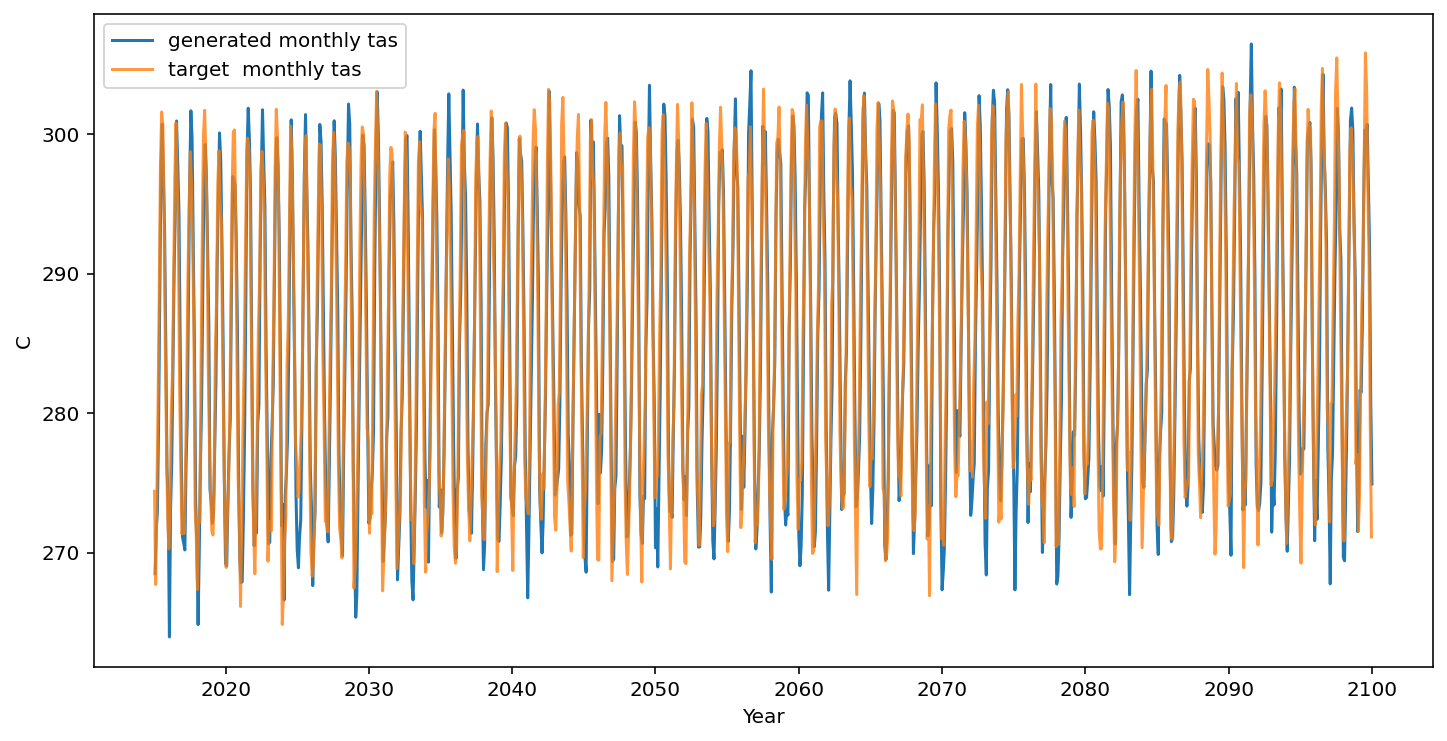

/var/folders/3t/b48tg9616bj3_bhcjwwll8cmg9cj39/T/ipykernel_64951/3917141202.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plt.plot(cp_pr_tar.indexes['time'].to_datetimeindex(),


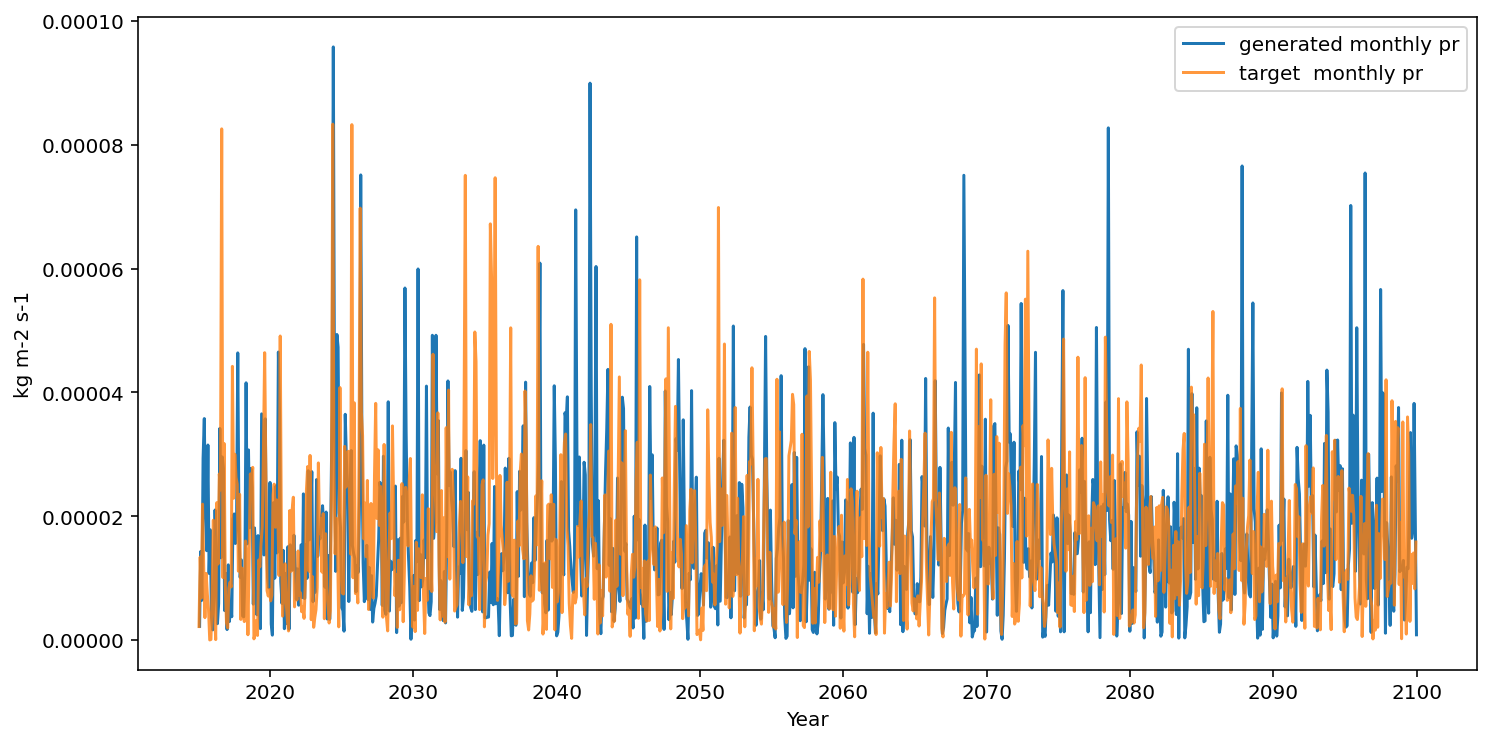

In [20]:
# lon and lat values for a grid cell near the Joint Global Change Research Institute in College Park, MD, USA
cp_lat = 38.9897
cp_lon = 180 + 76.9378

# lat and lon coordinates closest
abslat = np.abs(gen_tas.lat - cp_lat)
abslon = np.abs(gen_tas.lon-cp_lon)
c = np.maximum(abslon, abslat)
([lon_loc], [lat_loc]) = np.where(c == np.min(c))
lon_grid = gen_tas.lon[lon_loc]
lat_grid = gen_tas.lat[lat_loc]

cp_tas_gen = gen_tas.sel(lon=lon_grid, 
                         lat=lat_grid,
                         time=slice('2015-01-01', '2099-12-31')).copy()

cp_tas_tar = tar_tas.sel(lon=lon_grid, 
                         lat=lat_grid,
                         time=slice('2015-01-01', '2099-12-31')).copy()

cp_pr_gen = gen_pr.sel(lon=lon_grid, 
                       lat=lat_grid,
                       time=slice('2015-01-01', '2099-12-31')).copy()

cp_pr_tar = tar_pr.sel(lon=lon_grid, 
                       lat=lat_grid,
                       time=slice('2015-01-01', '2099-12-31')).copy()

# temperature (tas)
plt.plot(cp_tas_gen.time,
         cp_tas_gen.tas,
         label = 'generated monthly tas')
plt.plot(cp_tas_tar.indexes['time'].to_datetimeindex(),
         cp_tas_tar.tas,
         alpha=0.8,
         label = 'target  monthly tas')
plt.legend()
plt.xlabel("Year")
plt.ylabel("C")
plt.title("Actual and generate monthly precipitation (pr)")
plt.show()
plt.close()

# precipitation (pr)
plt.plot(cp_pr_gen.time,
         cp_pr_gen.pr,
         label = 'generated monthly pr')
plt.plot(cp_pr_tar.indexes['time'].to_datetimeindex(),
         cp_pr_tar.pr,
         alpha=0.8,
         label = 'target  monthly pr')
plt.legend()
plt.xlabel("Year")
plt.ylabel("kg m-2 s-1")
plt.title("Actual and generate monthly temperature (tas)")
plt.show()
plt.close


Visual validation of the complex spatial, temporal, and cross-variable
relationships present in ESM outputs is not possible. We extensively validate
that the method reproduces ESM internal variability in the ESD paper, but this
visual plotting at least suggests that nothing is obviously wrong.

In other words, it's not inconceivable from these plots that the orange time
series were sampled from the same underlying multivariate distribution that
generated the blue time series.